In [1]:
import arviz as az
import numpy as np  # For vectorized math operations

# import pandas as pd  # For file input/output
import pymc as pm
import pytensor.tensor as pt
from scipy.stats import gumbel_r

from matplotlib import pyplot as plt
import seaborn as sns

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [36]:
%config InlineBackend.figure_format='retina'

sns.set_theme(
    context="notebook",
    style="white",
    font="Latin Modern Roman",
    rc={
        "axes.spines.right": False,
        "axes.spines.top": False,
        "text.usetex": True,
    },
    palette="deep"
)

extra_params = {
    "text.latex.preamble": " ".join([r"\usepackage{mathtools}", r"\usepackage{amssymb}"])
}

plt.rcParams.update(extra_params)

In [21]:
n1_c = 999; n2_c = 999; n3_c = 999
cluster1 = np.random.randn(n1_c) + -1
cluster2 = np.random.randn(n2_c) + 0
cluster3 = np.random.randn(n3_c) + 2

x = np.concatenate((cluster1, cluster2, cluster3))
y = np.concatenate((1*np.ones(n1_c),
                    2*np.ones(n2_c),
                    3*np.ones(n3_c))) - 1

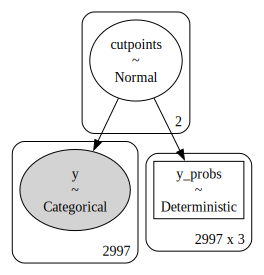

In [28]:
with pm.Model() as model:
    cutpoints = pm.Normal("cutpoints", mu=[-1,1], sigma=10, shape=2,
                          transform=pm.distributions.transforms.ordered)
    y_ = pm.OrderedProbit("y", cutpoints=cutpoints, eta=x, observed=y)
pm.model_to_graphviz(model)

In [29]:
with model:
    idata = pm.sample()
post = az.extract(idata)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cutpoints]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


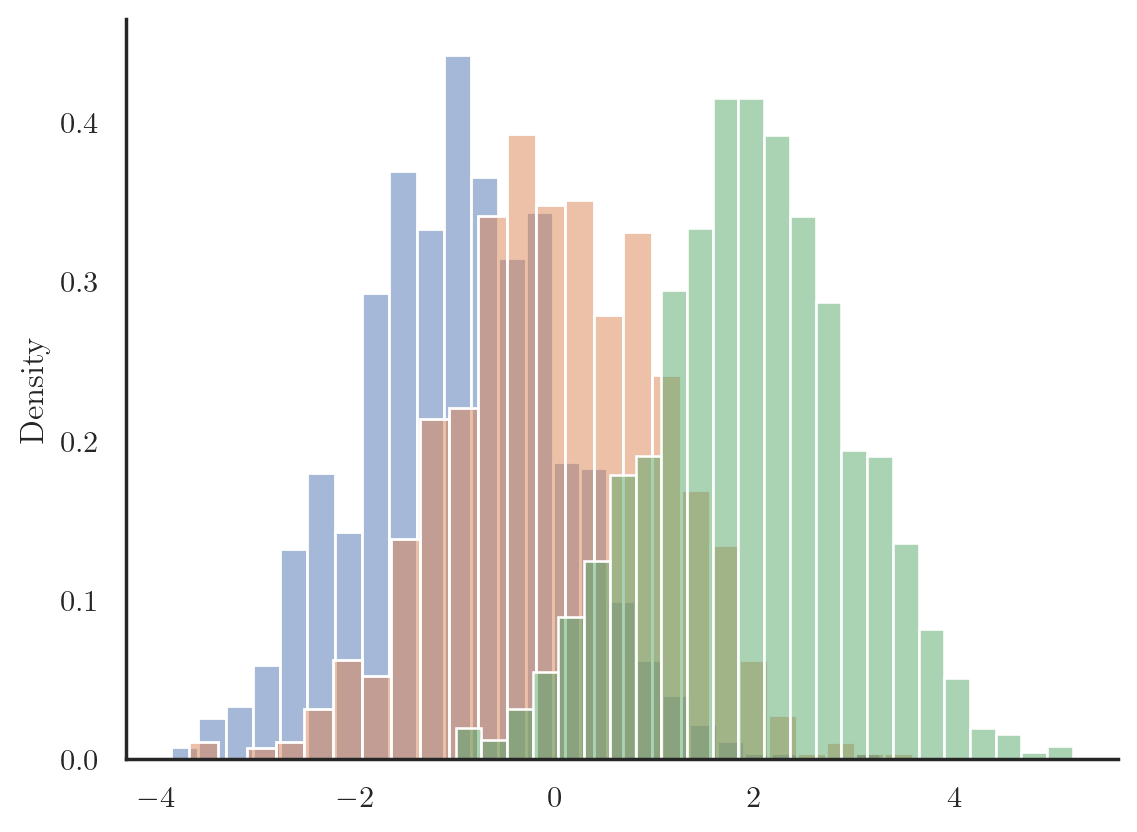

In [45]:
sns.histplot(x[y==0],alpha=0.5, stat="density")
sns.histplot(x[y==1],alpha=0.5, stat="density")
sns.histplot(x[y==2],alpha=0.5, stat="density")
plt.show()

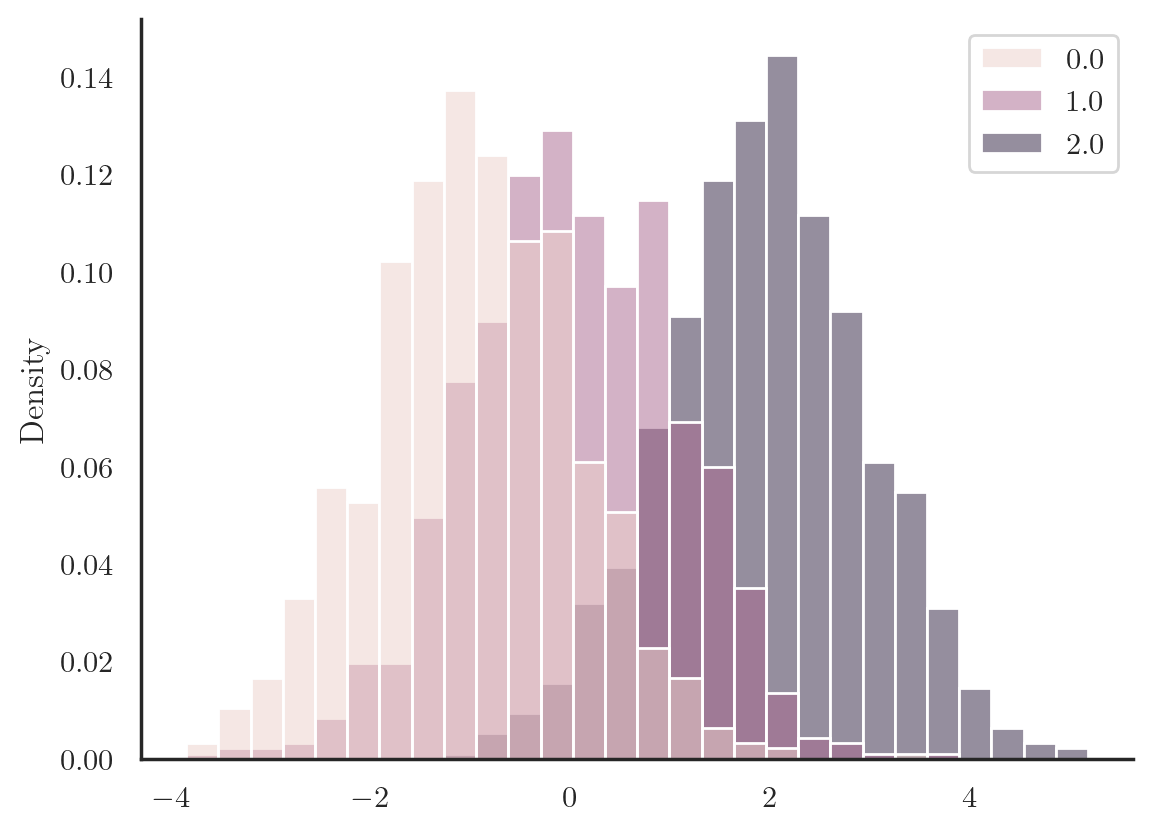

In [43]:
sns.histplot(x=x, hue=y, stat="density")
plt.show()

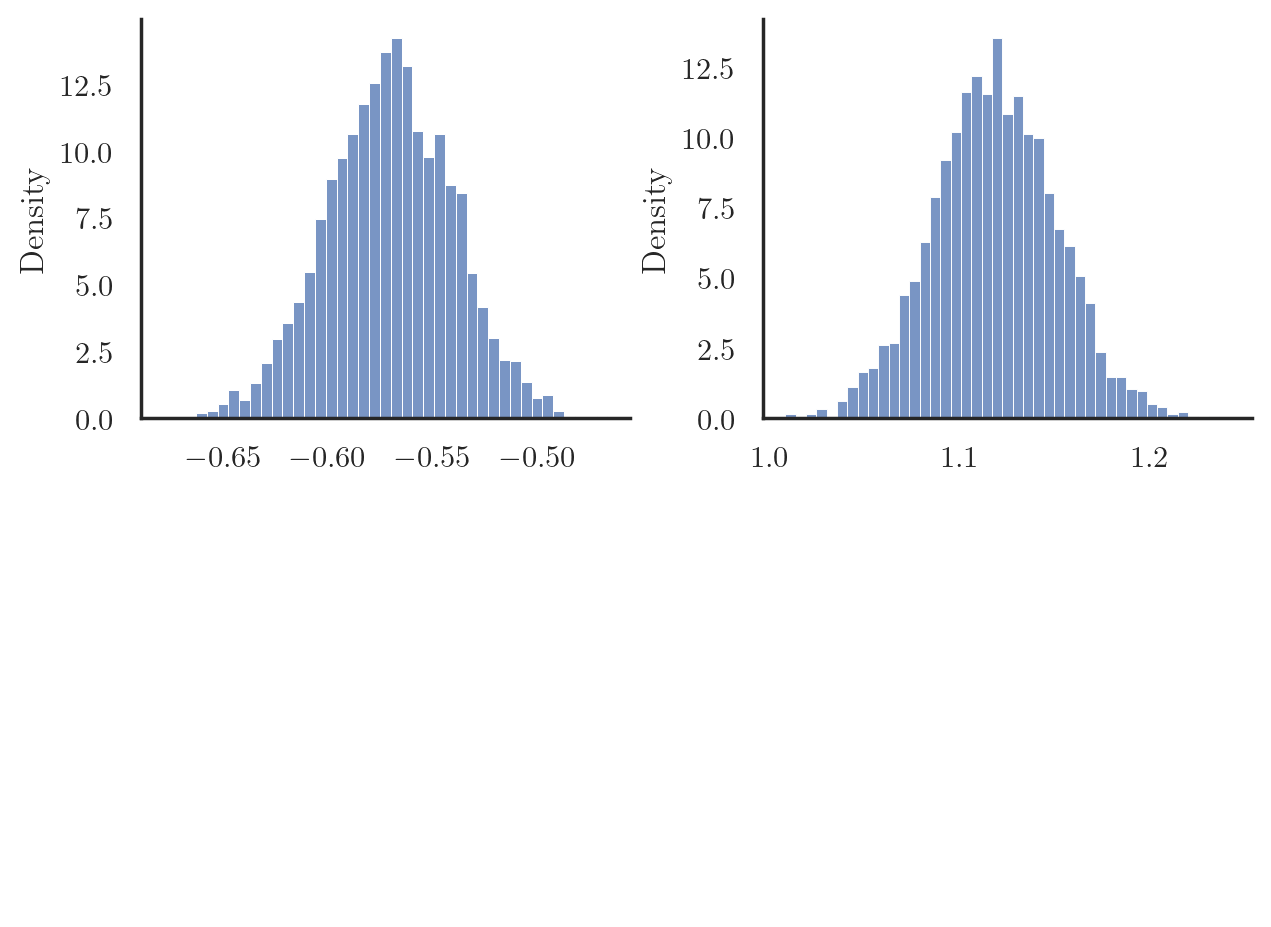

In [44]:
fig, axs = plt.subplots(2,2)

for i, ax in enumerate(axs.flatten()):
    plt.sca(ax)
    if i < 2:
        sns.histplot(post["cutpoints"][i, :], stat="density")
        # dgp_value = DGP_values[i]
        # plt.axvline(dgp_value, linestyle="dashed", color="black")
        # trans = plt.gca().get_xaxis_transform()
        # plt.text(x=dgp_value*1.01, y=0.95, s=rf"$\beta={dgp_value:.3f}$", transform=trans)
    else:
        plt.gca().axis('off')
plt.tight_layout()
plt.show()

Strange result. Here's Stata gode that replicates these phenomena. The bias is downwards on the \(\beta\) coefficient and upwards on the magnitude of the estimated cutpoints.

```stata
clear
local N = 999999
set obs `=`N'*3'

gen grp = 1 in 1/`=`N''
replace grp = 2 in `=`N'+1'/`=2*`N''
replace grp = 3 in `=2*`N'+1'/`=3*`N''

gen mu = .
replace mu = -1 if grp == 1
replace mu = +0 if grp == 2
replace mu = +2 if grp == 3

gen x = mu + rnormal()

reg x ibn.grp, noconstant // Just to make sure it's generated correctly
oprobit grp x
```